# WF-samples start here

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import xlrd
import numpy as np
import matplotlib.ticker as mtick
from openpyxl import load_workbook

def group(list):
    grouped=[]
    nonpolar=['G','A','V','L','I','P','F','W','M']
    polar=['S','T','C','Y','N','Q']
    basic=['K','R','H']
    acidic=['D','E']
    for item in list:
        new_item=''
        for letter in item:
            if letter in nonpolar:
                new_item+='N'
            if letter in polar:
                new_item+='P'
            if letter in basic:
                new_item+='B'
            if letter in acidic:
                new_item+='A'
        grouped.append(new_item)
    return grouped

def get_letter_frequency(list):
    letters={
        'A':0,
        'G':0,
        'V':0,
        'L':0,
        'I':0,
        'P':0,
        'F':0,
        'W':0,
        'M':0,
        'S':0,
        'T':0,
        'C':0,
        'Y':0,
        'N':0,
        'Q':0,
        'K':0,
        'R':0,
        'H':0,
        'D':0,
        'E':0
    }
    for word in list:
        for letter in word:
            letters[letter] +=1
    return letters

Normal_aminoacids={ #From swissprot
        'A':8.25,
        'G':3.93,
        'V':6.86,
        'L':9.65,
        'I':5.92,
        'P':4.73,
        'F':3.68,
        'W':1.09,
        'M':2.41,
        'S':6.63,
        'T':5.35,
        'C':1.38,
        'Y':2.92,
        'N':4.06,
        'Q':3.93,
        'K':5.81,
        'R':5.53,
        'H':2.27,
        'D':5.46,
        'E':6.72
    }

In [27]:

mapp='WF'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame() # the dataframe to be analyzed 
df_tot=pd.DataFrame()  # all peptides invluding modified
df_mod=pd.DataFrame() # modified with feature>=4
stdev_amount=[] # feature>=4 unmodified
stdev_amount_mod=[] # modified with feature >=4
stdev_length=[]
stdev_mass=[]
stdev_protein=[]
stdev_tot=[]

number_of_files=0
for file in files_xlsx:
    number_of_files+=1
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    stdev_tot.append(len(data.index))
    data['Accession'].fillna("Not available", inplace = True) 
    df_tot=df_tot.append(data)
    df_tot['Peptide']=df_tot['Peptide'].str.replace('[^a-zA-Z]','')
    print("# peptides in "+file+" "+str(len(data.index)))


    data = data.loc[(data['#Feature'] >= 4)]
    
    data_protein=data.copy()
    data_protein=data_protein.groupby(['Accession']).sum()
    stdev_protein.append(len(data_protein.index))

    
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    stdev_mass.append(data['Mass'].mean())
    stdev_length.append(data['Length'].mean())
    data['RT']=data['RT']/data['count']
    stdev_amount.append(len(data.index))
    print('# of peptides with feat>=4 in '+file+': '+str(len(data.index)))
    df = df.append(data)  # appends all data


df['count'] = 1
df = df.groupby(['Peptide','Accession']).sum()
df.reset_index(['Peptide'], inplace=True)

df['N-cut']=df['Peptide'].apply(lambda x: x[0:4])
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df['First aa']=df['Peptide'].apply(lambda x: x[0:1])
df['Last aa']=df['Peptide'].apply(lambda x: x[-1::1])

df['Spectral count']=df['#Feature']
df['Spectral count WF1']=df['#Feature WF1']
df['Spectral count WF2']=df['#Feature WF2']
df['Spectral count WF3']=df['#Feature WF 3']
df['Spectral count WF4']=df['#Feature WF4']
df['Spectral count WF5']=df['#Feature WF5']
df = df[['Peptide', 'Mass', 'Length', 'RT', 'Spectral count', 'Spectral count WF1','Spectral count WF2', 'Spectral count WF3', 'Spectral count WF4','Spectral count WF5','count', 'N-cut', 'C-cut','First aa','Last aa']]
df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['Spectral count','Accession','count'], ascending=False)

aminoacids = get_letter_frequency(df['Peptide']*df['count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['count'])
First_aa=get_letter_frequency(df['First aa']*df['count'])
Last_aa=get_letter_frequency(df['Last aa']*df['count'])

print("Standard deviation TOTAL: "+str(np.std(stdev_tot)))
print("Standard deviation unmod and feat>=4: "+ str(np.std(stdev_amount)))
print("Standard deviation length: "+ str(np.std(stdev_length)))
print("Standard deviation mass: "+ str(np.std(stdev_mass)))
print("Standard deviation protein: "+str(np.std(stdev_protein)))

print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))

print('# of peptides in all files: ' +str(sum(stdev_tot)))
df_tot=df_tot.groupby(df_tot['Peptide']).sum()
print('# of unique peptides: '+str(len(df_tot.index)))


print("# peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(len(df_tot.index)))+" %")

df_protein=df.copy()
df_protein.reset_index('Accession', inplace=True)
df_protein=df_protein.groupby(['Accession']).sum()
print("# of proteins: " + str(len(df_protein.index)))

df

# peptides in peptide _WF1.xlsx 3687
# of peptides with feat>=4 in peptide _WF1.xlsx: 811
# peptides in peptide_WF2.xlsx 4220
# of peptides with feat>=4 in peptide_WF2.xlsx: 934
# peptides in peptide_WF3.xlsx 2960
# of peptides with feat>=4 in peptide_WF3.xlsx: 900
# peptides in peptide_WF4.xlsx 2423
# of peptides with feat>=4 in peptide_WF4.xlsx: 572
# peptides in peptide_WF5.xlsx 3367
# of peptides with feat>=4 in peptide_WF5.xlsx: 846
Standard deviation TOTAL: 613.2629452363807
Standard deviation unmod and feat>=4: 127.57993572658673
Standard deviation length: 0.32194222610917256
Standard deviation mass: 29.419219052207136
Standard deviation protein: 19.809088823063014
Average length: 12.641101278269419
Average mass: 1403.0534716730854
# of peptides in all files: 16657
# of unique peptides: 7175
# peptides with feature>=4: 2034, in percent: 28.34843205574913 %
# of proteins: 232


,Peptide,Mass,Length,RT,Spectral count,Spectral count WF1,Spectral count WF2,Spectral count WF3,Spectral count WF4,Spectral count WF5,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,,,
sp|Q04206|TF65_HUMAN,PSLQAPVR,866.4974,8.0,14.880000,160,23.0,8.0,38.0,52.0,38.0,5,PSLQ,APVR,P,R
sp|P01009|A1AT_HUMAN,AVLTIDEKGTEAAGAMF,1738.8447,17.0,67.552500,103,6.0,0.0,47.0,12.0,38.0,4,AVLT,GAMF,A,F
sp|P04406|G3P_HUMAN,AVGKVIPELNGKLTGMAF,1860.6082,18.0,73.212000,65,12.0,12.0,16.0,18.0,7.0,5,AVGK,GMAF,A,F
sp|Q14624|ITIH4_HUMAN,NFRPGVL,802.0401,7.0,41.191000,58,13.0,13.0,14.0,6.0,12.0,5,NFRP,PGVL,N,L
sp|P06727|APOA4_HUMAN,NHQLEGLTF,1058.2737,9.0,66.895667,58,9.0,11.0,10.0,15.0,13.0,5,NHQL,GLTF,N,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Not available,TSLEVSPNPEPPEKPV,1718.8726,16.0,37.620000,4,0.0,0.0,4.0,0.0,0.0,1,TSLE,EKPV,T,V
Not available,VDVLEDKL,929.5070,8.0,37.080000,4,0.0,0.0,0.0,0.0,4.0,1,VDVL,EDKL,V,L
Not available,VGAGAPVYLAAVLEYLTAEILELAGN,2616.4050,26.0,118.720000,4,0.0,4.0,0.0,0.0,0.0,1,VGAG,LAGN,V,N


### Aminoacid profile

Text(0.5, 1.0, 'Last aminoacid')

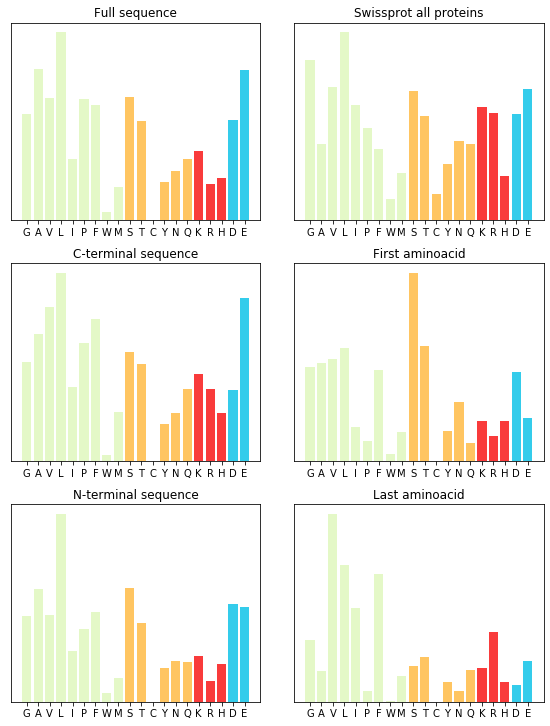

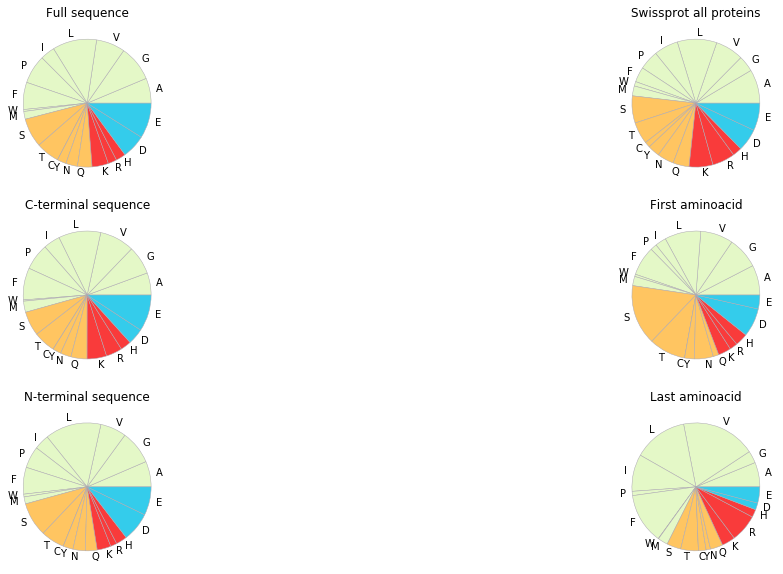

In [20]:

color=['#e4f8c7', '#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#ffc561','#ffc561','#ffc561','#ffc561','#ffc561','#ffc561','#f93b3b','#f93b3b','#f93b3b','#34cceb','#34cceb','#34cceb']


fig, ax1 = plt.subplots(3,2,figsize=(8,10))
ax1[0,0].bar(range(len(aminoacids)), list(aminoacids.values()), align='center', color=color)
ax1[2,0].bar(range(len(N_aminoacids)), list(N_aminoacids.values()), align='center', color=color)
ax1[1,0].bar(range(len(C_aminoacids)), list(C_aminoacids.values()), align='center', color=color)
ax1[1,1].bar(range(len(First_aa)), list(First_aa.values()), align='center', color=color)
ax1[2,1].bar(range(len(Last_aa)), list(Last_aa.values()), align='center', color=color)
ax1[0,1].bar(range(len(Normal_aminoacids)), list(Normal_aminoacids.values()), align='center', color=color)

ax1[0,0].set_title('Full sequence')
ax1[0,1].set_title('Swissprot all proteins')
ax1[2,0].set_title('N-terminal sequence')
ax1[1,0].set_title('C-terminal sequence')
ax1[1,1].set_title('First aminoacid')
ax1[2,1].set_title('Last aminoacid')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.setp(ax1, xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], xticklabels=['G','A','V','L','I','P','F','W','M','S','T','C','Y','N','Q','K','R','H','D','E'], yticks=([]))

fig, ax = plt.subplots(3,2,figsize=(20,10))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 

ax[0,0].pie(aminoacids.values(),labels = aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[2,0].pie(N_aminoacids.values(),labels =N_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,0].pie(C_aminoacids.values(),labels = C_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,1].pie(First_aa.values(),labels = First_aa.keys(), colors=color, wedgeprops=wp) 
ax[2,1].pie(Last_aa.values(),labels = Last_aa.keys(), colors=color, wedgeprops=wp) 
ax[0,1].pie(Normal_aminoacids.values(),labels = Normal_aminoacids.keys(), colors=color, wedgeprops=wp) 

ax[0,0].set_title('Full sequence')
ax[0,1].set_title('Swissprot all proteins')
ax[2,0].set_title('N-terminal sequence')
ax[1,0].set_title('C-terminal sequence')
ax[1,1].set_title('First aminoacid')
ax[2,1].set_title('Last aminoacid')

## Graph of aminoacid frequency in complete sequences

### How does feature and count correlate in these samples? Are there certain peptides with abnormal feature?

[ 5.83630578 -2.05895298]
0.6928942160318461


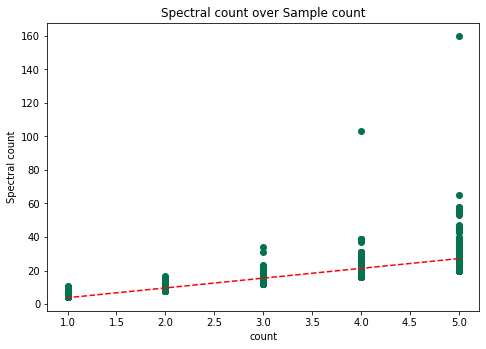

In [28]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['count'], df['Spectral count'], color='#04724d')
z = np.polyfit(df['count'], df['Spectral count'], 1)
p = np.poly1d(z)
ax.set_xlabel('count')
ax.set_ylabel('Spectral count')
ax.set_title('Spectral count over Sample count')
plt.plot(df['count'],p(df['count']),"r--")
fig.savefig('SPC_WF.svg',transparent=True)


correlation_matrix = np.corrcoef(df['count'], df['Spectral count'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(z)
print(r_squared)

In [43]:
df.sort_values(['Spectral count'], ascending=False).head()


,Peptide,Mass,Length,RT,Spectral count,Spectral count Sample 13,Spectral count Sample 21,Spectral count Sample 33,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,
sp|P02671|FIBA_HUMAN,MELERPGGNEITR,1510.058861,13.0,54.533333,92,16.0,35.0,40.0,3,MELE,EITR,M,R
sp|P02671|FIBA_HUMAN,MELERPGGNEIT,1352.016542,12.0,63.580556,62,16.0,32.0,13.0,3,MELE,NEIT,M,T
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.525000,9.0,57.370000,46,8.0,12.0,26.0,3,ANAL,HKYH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.614900,11.0,89.106667,43,13.0,13.0,17.0,3,GVAN,HKYH,G,H
sp|P69905|HBA_HUMAN,VGAHAGEYGAEALER,1528.726900,15.0,58.986667,41,16.0,14.0,11.0,3,VGAH,ALER,V,R


### What are the most frequent N,C-terminals and what is their sequence? How often are they found? Are there outliers? OOPS: Mass length etc are fucked

In [35]:
#Here we sort on the C and N-cut

df_N=df.groupby(['Accession', 'N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
df_N['Spectral count']=df_N['Spectral count']/number_of_files
df_N=df_N.sort_values(['Spectral count'], ascending=False)
df_C=df.groupby(['Accession', 'C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C['Spectral count']=df_C['Spectral count']/number_of_files
df_C=df_C.sort_values(['Spectral count'], ascending=False)

df_N.head()


,,Spectral count,Spectral count WF1,Spectral count WF2,Spectral count WF3,Spectral count WF4,Spectral count WF5,count
Accession,N-cut,,,,,,,
sp|P69905|HBA_HUMAN,TYFP,45.8,53.0,54.0,59.0,10.0,53.0,39
sp|P01009|A1AT_HUMAN,AVLT,41.2,23.0,17.0,79.0,18.0,69.0,27
sp|P06727|APOA4_HUMAN,SLAE,33.4,23.0,36.0,34.0,43.0,30.0,28
sp|Q04206|TF65_HUMAN,PSLQ,32.0,23.0,8.0,38.0,52.0,38.0,5
sp|P69905|HBA_HUMAN,SLDK,30.6,44.0,43.0,26.0,0.0,40.0,30


1210
1072


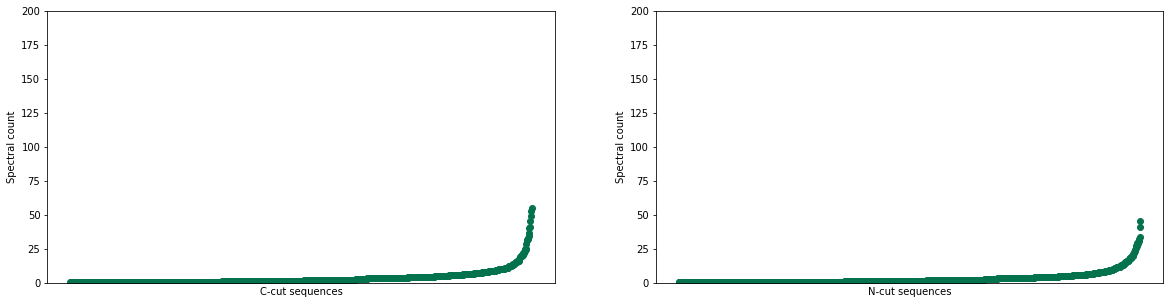

In [36]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.

df_N.reset_index(['Accession'], inplace=True)
df_C.reset_index(['Accession'], inplace=True)
df_C=df.groupby(['C-cut']).sum()
df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values('Spectral count')
df_C=df_C.sort_values('Spectral count')
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
plt.setp(ax, ylim=(0,200))
ax[1].scatter(df_N.index, df_N['Spectral count']/number_of_files, color='#04724d') #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['Spectral count']/number_of_files, color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))

### What are the most frequent groups of AA at the N,C-terminal? Are there any combinations?

In [37]:
#This adds the N/C-grouped column when df is grouped mainly on protein, although the index is removed, and then on N/C-cutsite which is kept. 
#It is therefore still indirectly sorted on protein. There is no "respective peptide" available, although this can be easily added by sorting on Peptide aswell.

#might be an easier way to code

df_N= df.groupby(['Accession','N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['count','Spectral count'], ascending=False) #sorts these values by count and feature
df_N.reset_index(['Accession'], inplace=True) #removes protein from index, only cut left
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead
df_N['Spectral count']=df_N['Spectral count']/number_of_files

df_N=df_N.sort_values(['Spectral count'], ascending=False) #sorts the grouped index on count and feature

df_C = df.groupby(['Accession','C-cut']).sum() 
df_C = df_C.sort_values(['count','Spectral count'], ascending=False)
df_C.reset_index(['Accession'], inplace=True)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C=df_C.groupby(['C-grouped']).sum()
df_C['Spectral count']=df_C['Spectral count']/number_of_files

df_C=df_C.sort_values(['Spectral count'], ascending=False)
df_C.head()




,Spectral count,Spectral count WF1,Spectral count WF2,Spectral count WF3,Spectral count WF4,Spectral count WF5,count
C-grouped,,,,,,,
NNNN,265.8,265.0,254.0,293.0,178.0,337.0,254
NPNN,189.4,217.0,292.0,163.0,125.0,150.0,211
NABN,176.8,181.0,222.0,158.0,102.0,220.0,164
NANN,145.4,153.0,164.0,165.0,125.0,120.0,163
PNNN,121.6,106.0,154.0,103.0,87.0,158.0,144


169
167


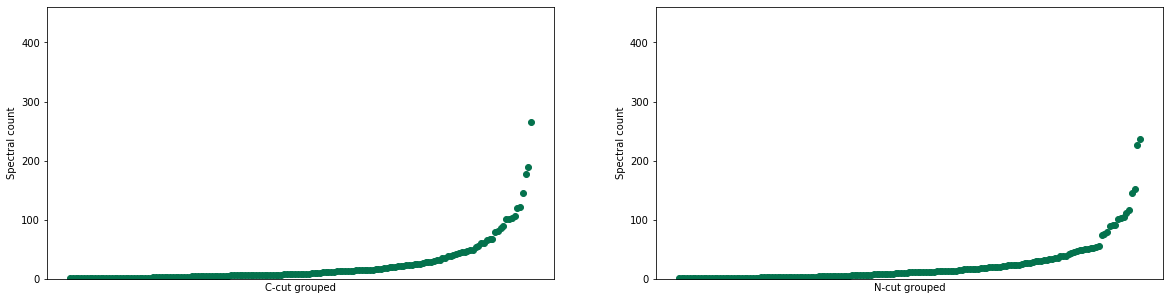

In [38]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
df_N=df_N.sort_values(['Spectral count'], ascending=True)
df_C=df_C.sort_values(['Spectral count'], ascending=True)
fig, ax = plt.subplots(1,2, figsize=(20,5))
plt.setp(ax, ylim=(0,460))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count'], color='#04724d') #row=0, col=0
ax[0].scatter(df_C.index, df_C['Spectral count'], color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))

# Infected samples start here

In [39]:
mapp='peptide_sample_inf'

files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame() # the dataframe to be analyzed 
df_tot=pd.DataFrame()  # all peptides invluding modified
df_mod=pd.DataFrame() # modified with feature>=4
stdev_amount=[] # feature>=4 unmodified
stdev_amount_mod=[] # modified with feature >=4
stdev_length=[]
stdev_mass=[]
stdev_protein=[]
stdev_tot=[]
number_of_files=0
for file in files_xlsx:
    number_of_files+=1
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    stdev_tot.append(len(data.index))
    data['Accession'].fillna("Not available", inplace = True) 
    df_tot=df_tot.append(data)
    df_tot['Peptide']=df_tot['Peptide'].str.replace('[^a-zA-Z]','')
    print("# peptides in "+file+" "+str(len(data.index)))
    
    data = data.loc[(data['#Feature'] >= 4)]
    
    data_protein=data.copy()
    data_protein=data_protein.groupby(['Accession']).sum()
    stdev_protein.append(len(data_protein.index))
    
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    stdev_mass.append(data['Mass'].mean())
    stdev_length.append(data['Length'].mean())
    data['RT']=data['RT']/data['count']
    stdev_amount.append(len(data.index))
    print('# of peptides with feat>=4 in '+file+': '+str(len(data.index)))
    df = df.append(data)  # appends all data


df['count'] = 1
df = df.groupby(['Peptide','Accession']).sum()
df.reset_index(['Peptide'], inplace=True)

df['N-cut']=df['Peptide'].apply(lambda x: x[0:4])
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df['First aa']=df['Peptide'].apply(lambda x: x[0:1])
df['Last aa']=df['Peptide'].apply(lambda x: x[-1::1])


df['Spectral count']=df['#Feature']
df['Spectral count Sample 31']= df['#Feature Sample 31']
df['Spectral count Sample 34']=df['#Feature Sample 34']
df['Spectral count Sample 39']=df['#Feature Sample 39']
df = df[['Peptide', 'Mass', 'Length', 'RT', 'Spectral count', 'Spectral count Sample 31','Spectral count Sample 34', 'Spectral count Sample 39','count', 'N-cut', 'C-cut', 'First aa', 'Last aa']]

df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['Spectral count','Accession','count'], ascending=False)

aminoacids = get_letter_frequency(df['Peptide']*df['count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['count'])
First_aa=get_letter_frequency(df['First aa']*df['count'])
Last_aa=get_letter_frequency(df['Last aa']*df['count'])

print("Standard deviation TOTAL: "+str(np.std(stdev_tot)))
print("Standard deviation unmod and feat>=4: "+ str(np.std(stdev_amount)))
print("Standard deviation length: "+ str(np.std(stdev_length)))
print("Standard deviation mass: "+ str(np.std(stdev_mass)))
print("Standard deviation protein: "+str(np.std(stdev_protein)))

print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))

print('# of peptides in all files: ' +str(sum(stdev_tot)))
df_tot=df_tot.groupby(df_tot['Peptide']).sum()
print('# of unique peptides: '+str(len(df_tot.index)))

print("# peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(len(df_tot.index)))+" %")

df_protein=df.copy()
df_protein.reset_index('Accession', inplace=True)
df_protein=df_protein.groupby(['Accession']).sum()
print("# of proteins: " + str(len(df_protein.index)))

df

# peptides in peptide_sample_31.xlsx 5103
# of peptides with feat>=4 in peptide_sample_31.xlsx: 884
# peptides in peptide_sample_34.xlsx 1412
# of peptides with feat>=4 in peptide_sample_34.xlsx: 196
# peptides in peptide_sample_39.xlsx 4929
# of peptides with feat>=4 in peptide_sample_39.xlsx: 1056
Standard deviation TOTAL: 1700.4262864221887
Standard deviation unmod and feat>=4: 371.5624667087173
Standard deviation length: 1.3133418080983053
Standard deviation mass: 143.02792515872824
Standard deviation protein: 23.612614331233114
Average length: 13.4072553045859
Average mass: 1459.3089345653664
# of peptides in all files: 11444
# of unique peptides: 6483
# peptides with feature>=4: 1461, in percent: 22.535863026376678 %
# of proteins: 103


,Peptide,Mass,Length,RT,Spectral count,Spectral count Sample 31,Spectral count Sample 34,Spectral count Sample 39,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,1250.8160,12.0,88.983333,109,37.0,12.0,60.0,3,AGVA,HKYH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.9429,11.0,75.975000,109,42.0,12.0,55.0,3,GVAN,HKYH,G,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.6890,9.0,70.753333,94,33.0,9.0,52.0,3,ANAL,HKYH,A,H
sp|P68871|HBB_HUMAN,VHLTPEEKSAV,1208.6400,11.0,50.666667,78,28.0,14.0,36.0,3,VHLT,KSAV,V,V
sp|P69905|HBA_HUMAN,STVLTSKYR,1053.5818,9.0,119.810000,77,21.0,15.0,41.0,3,STVL,SKYR,S,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Not available,SGFLIFPSA,937.4908,9.0,137.280000,4,0.0,0.0,4.0,1,SGFL,FPSA,S,A
Not available,SLGSKINVK,944.5654,9.0,39.030000,4,0.0,0.0,4.0,1,SLGS,INVK,S,K
Not available,SVYVYKVLK,1097.6484,9.0,64.990000,4,4.0,0.0,0.0,1,SVYV,KVLK,S,K


Text(0.5, 1.0, 'Last aminoacid')

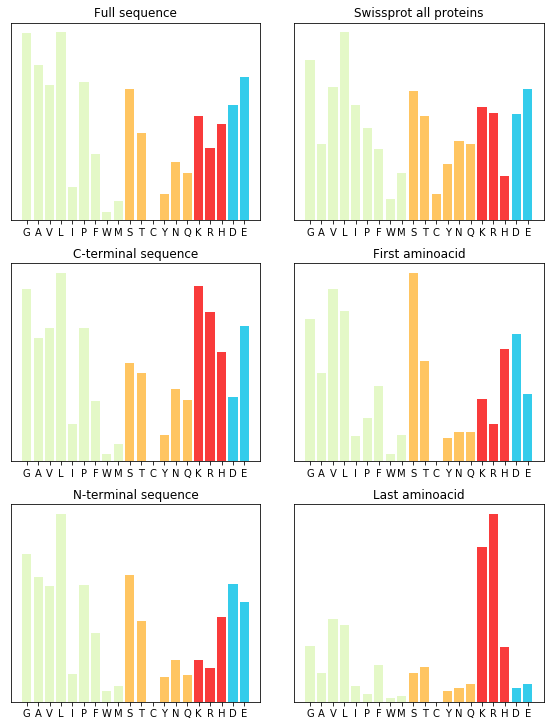

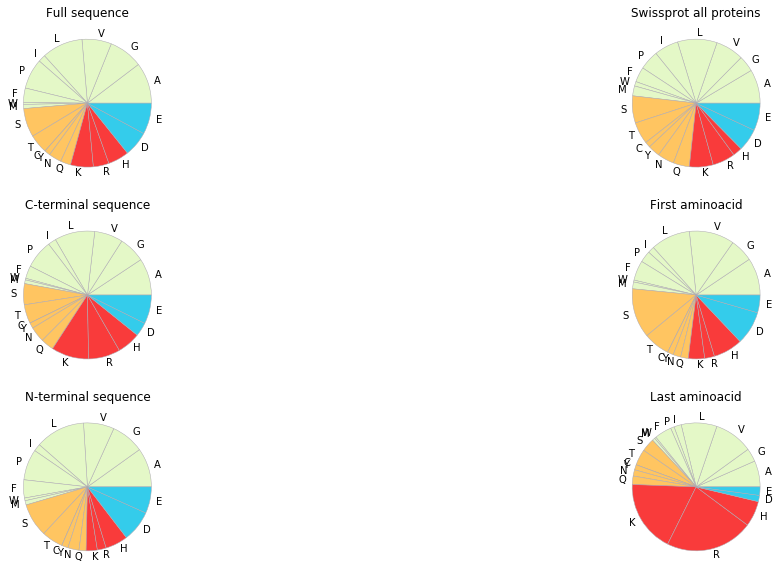

In [53]:

color=['#e4f8c7', '#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#ffc561','#ffc561','#ffc561','#ffc561','#ffc561','#ffc561','#f93b3b','#f93b3b','#f93b3b','#34cceb','#34cceb','#34cceb']


fig, ax1 = plt.subplots(3,2,figsize=(8,10))
ax1[0,0].bar(range(len(aminoacids)), list(aminoacids.values()), align='center', color=color)
ax1[2,0].bar(range(len(N_aminoacids)), list(N_aminoacids.values()), align='center', color=color)
ax1[1,0].bar(range(len(C_aminoacids)), list(C_aminoacids.values()), align='center', color=color)
ax1[1,1].bar(range(len(First_aa)), list(First_aa.values()), align='center', color=color)
ax1[2,1].bar(range(len(Last_aa)), list(Last_aa.values()), align='center', color=color)
ax1[0,1].bar(range(len(Normal_aminoacids)), list(Normal_aminoacids.values()), align='center', color=color)

ax1[0,0].set_title('Full sequence')
ax1[0,1].set_title('Swissprot all proteins')
ax1[2,0].set_title('N-terminal sequence')
ax1[1,0].set_title('C-terminal sequence')
ax1[1,1].set_title('First aminoacid')
ax1[2,1].set_title('Last aminoacid')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.setp(ax1, xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], xticklabels=['G','A','V','L','I','P','F','W','M','S','T','C','Y','N','Q','K','R','H','D','E'], yticks=([]))

fig, ax = plt.subplots(3,2,figsize=(20,10))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 

ax[0,0].pie(aminoacids.values(),labels = aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[2,0].pie(N_aminoacids.values(),labels =N_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,0].pie(C_aminoacids.values(),labels = C_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,1].pie(First_aa.values(),labels = First_aa.keys(), colors=color, wedgeprops=wp) 
ax[2,1].pie(Last_aa.values(),labels = Last_aa.keys(), colors=color, wedgeprops=wp) 
ax[0,1].pie(Normal_aminoacids.values(),labels = Normal_aminoacids.keys(), colors=color, wedgeprops=wp) 

ax[0,0].set_title('Full sequence')
ax[0,1].set_title('Swissprot all proteins')
ax[2,0].set_title('N-terminal sequence')
ax[1,0].set_title('C-terminal sequence')
ax[1,1].set_title('First aminoacid')
ax[2,1].set_title('Last aminoacid')

[10.35027083 -5.55043018]
0.4688525183089574


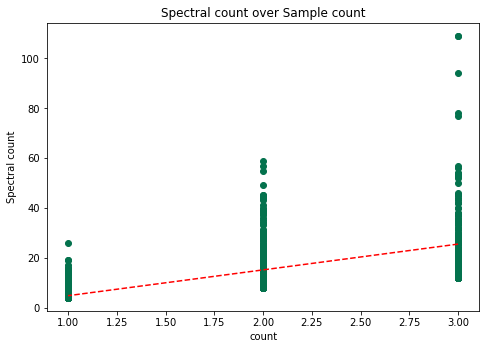

In [40]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['count'], df['Spectral count'], color='#04724d')
z = np.polyfit(df['count'], df['Spectral count'], 1)
p = np.poly1d(z)
plt.plot(df['count'],p(df['count']),"r--")
ax.set_xlabel('count')
ax.set_ylabel('Spectral count')
ax.set_title('Spectral count over Sample count')
fig.savefig('SPC_INF.svg',transparent=True)

correlation_matrix = np.corrcoef(df['count'], df['Spectral count'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(z)
print(r_squared)

In [13]:
df.sort_values(['Spectral count'], ascending=False)

,Peptide,Mass,Length,RT,Spectral count,Spectral count Sample 31,Spectral count Sample 34,Spectral count Sample 39,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,1250.8160,12.0,88.983333,109,37.0,12.0,60.0,3,AGVA,HKYH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.9429,11.0,75.975000,109,42.0,12.0,55.0,3,GVAN,HKYH,G,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.6890,9.0,70.753333,94,33.0,9.0,52.0,3,ANAL,HKYH,A,H
sp|P68871|HBB_HUMAN,VHLTPEEKSAV,1208.6400,11.0,50.666667,78,28.0,14.0,36.0,3,VHLT,KSAV,V,V
sp|P69905|HBA_HUMAN,STVLTSKYR,1053.5818,9.0,119.810000,77,21.0,15.0,41.0,3,STVL,SKYR,S,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,YQKVVAGVANALA,1302.7295,13.0,85.270000,4,4.0,0.0,0.0,1,YQKV,NALA,Y,A
sp|P68871|HBB_HUMAN,AFSDGLAHLDNLKGTFA,1775.8842,17.0,102.940000,4,0.0,0.0,4.0,1,AFSD,GTFA,A,A
sp|P68871|HBB_HUMAN,AHHFGKEFTPPV,1365.6829,12.0,61.660000,4,4.0,0.0,0.0,1,AHHF,TPPV,A,V


In [14]:
#Here we sort on the C and N-cut


df_N=df.groupby(['Accession', 'N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
df_N['Spectral count']=df_N['Spectral count']/number_of_files
df_N=df_N.sort_values(['Spectral count'], ascending=False)
df_C=df.groupby(['Accession', 'C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C['Spectral count']=df_C['Spectral count']/number_of_files
df_C=df_C.sort_values(['Spectral count'], ascending=False)

df_N.head()

,,Spectral count,Spectral count Sample 31,Spectral count Sample 34,Spectral count Sample 39,count
Accession,N-cut,,,,,
sp|P69905|HBA_HUMAN,VLSP,134.000000,151.0,48.0,203.0,43
sp|P68871|HBB_HUMAN,VHLT,97.000000,112.0,32.0,147.0,30
sp|P69905|HBA_HUMAN,TYFP,95.333333,134.0,5.0,147.0,38
sp|P68871|HBB_HUMAN,GDLS,75.000000,103.0,0.0,122.0,20
sp|P69905|HBA_HUMAN,FDLS,71.666667,56.0,35.0,124.0,33


610
586


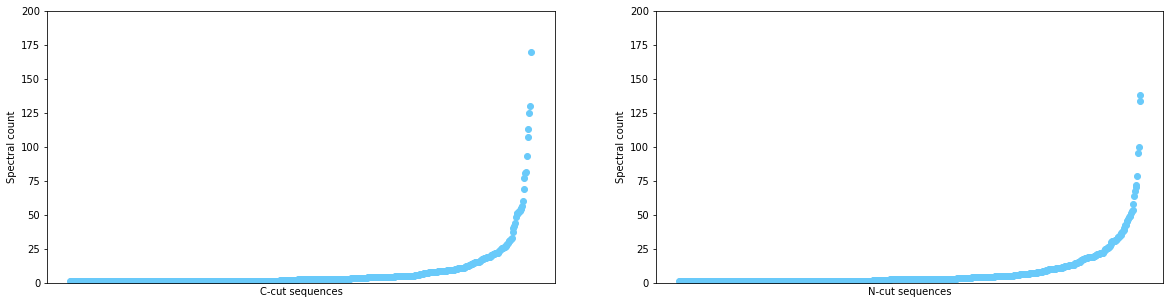

In [15]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.

df_N.reset_index(['Accession'], inplace=True)
df_C.reset_index(['Accession'], inplace=True)
df_C=df.groupby(['C-cut']).sum()
df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values('Spectral count')
df_C=df_C.sort_values('Spectral count')
fig, ax = plt.subplots(1,2,figsize=(20,5))
plt.setp(ax, ylim=(0,200))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count']/number_of_files, color='#04724d') #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['Spectral count']/number_of_files, color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))

In [16]:
#This adds the N/C-grouped column when df is grouped mainly on protein, although the index is removed, and then on N/C-cutsite which is kept. 
#It is therefore still indirectly sorted on protein. There is no "respective peptide" available, although this can be easily added by sorting on Peptide aswell.



df_N= df.groupby(['Accession','N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['count','Spectral count'], ascending=False) #sorts these values by count and feature
df_N.reset_index(['Accession'], inplace=True) #removes protein from index, only cut left
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead
df_N['Spectral count']=df_N['Spectral count']/number_of_files

df_N=df_N.sort_values(['Spectral count'], ascending=False) #sorts the grouped index on count and feature

df_C = df.groupby(['Accession','C-cut']).sum() 
df_C = df_C.sort_values(['count','Spectral count'], ascending=False)
df_C.reset_index(['Accession'], inplace=True)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C=df_C.groupby(['C-grouped']).sum()
df_C['Spectral count']=df_C['Spectral count']/number_of_files

df_C=df_C.sort_values(['Spectral count'], ascending=False)
df_C.head()


,Spectral count,Spectral count Sample 31,Spectral count Sample 34,Spectral count Sample 39,count
C-grouped,,,,,
NPNN,397.666667,489.0,74.0,629.0,148
BBPB,241.333333,225.0,49.0,450.0,40
NABN,231.666667,288.0,26.0,381.0,63
BNNN,206.000000,278.0,38.0,301.0,90
NNNB,198.666667,238.0,68.0,290.0,110


159
149


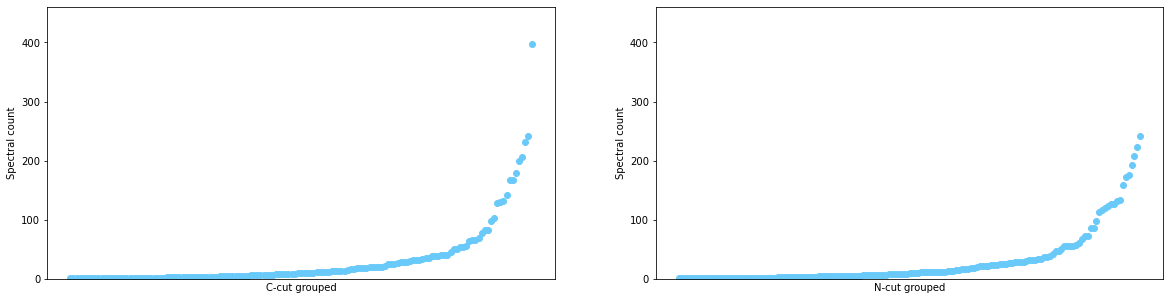

In [17]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
df_N=df_N.sort_values(['Spectral count'], ascending=True)
df_C=df_C.sort_values(['Spectral count'], ascending=True)
fig, ax = plt.subplots(1,2, figsize=(20,5))
plt.setp(ax, ylim=(0,460))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count'], color='#04724d') #row=0, col=0
ax[0].scatter(df_C.index, df_C['Spectral count'], color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))

# Non-infected samples start here

In [41]:
mapp='peptide_sample_ninf'

files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame() # the dataframe to be analyzed 
df_tot=pd.DataFrame()  # all peptides invluding modified
df_mod=pd.DataFrame() # modified with feature>=4
stdev_amount=[] # feature>=4 unmodified
stdev_amount_mod=[] # modified with feature >=4
stdev_length=[]
stdev_mass=[]
stdev_protein=[]
stdev_tot=[]
number_of_files=0
for file in files_xlsx:
    number_of_files+=1
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    stdev_tot.append(len(data.index))
    data['Accession'].fillna("Not available", inplace = True) 
    df_tot=df_tot.append(data)
    df_tot['Peptide']=df_tot['Peptide'].str.replace('[^a-zA-Z]','')
    print("# peptides in "+file+" "+str(len(data.index)))
    
    data = data.loc[(data['#Feature'] >= 4)]
    
    data_protein=data.copy()
    data_protein=data_protein.groupby(['Accession']).sum()
    stdev_protein.append(len(data_protein.index))
    
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    stdev_mass.append(data['Mass'].mean())
    stdev_length.append(data['Length'].mean())
    data['RT']=data['RT']/data['count']
    stdev_amount.append(len(data.index))
    print('# of peptides with feat>=4 in '+file+': '+str(len(data.index)))
    df = df.append(data)  # appends all data

df['count'] = 1
df = df.groupby(['Peptide','Accession']).sum()
df.reset_index(['Peptide'], inplace=True)

df['N-cut']=df['Peptide'].apply(lambda x: x[0:4])
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df['First aa']=df['Peptide'].apply(lambda x: x[0:1])
df['Last aa']=df['Peptide'].apply(lambda x: x[-1::1])

df['Spectral count']=df['#Feature']
df['Spectral count Sample 13']=df['#Feature Sample 13']
df['Spectral count Sample 21']=df['#Feature Sample 21']
df['Spectral count Sample 33']=df['#Feature Sample 33']
df = df[['Peptide', 'Mass', 'Length', 'RT', 'Spectral count', 'Spectral count Sample 13','Spectral count Sample 21', 'Spectral count Sample 33','count', 'N-cut', 'C-cut','First aa','Last aa']]

df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['Spectral count','Accession','count'], ascending=False)

aminoacids = get_letter_frequency(df['Peptide']*df['count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['count'])
First_aa=get_letter_frequency(df['First aa']*df['count'])
Last_aa=get_letter_frequency(df['Last aa']*df['count'])

print("Standard deviation TOTAL: "+str(np.std(stdev_tot)))
print("Standard deviation unmod and feat>=4: "+ str(np.std(stdev_amount)))
print("Standard deviation length: "+ str(np.std(stdev_length)))
print("Standard deviation mass: "+ str(np.std(stdev_mass)))
print("Standard deviation protein: "+str(np.std(stdev_protein)))

print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))

print('# of peptides in all files: ' +str(sum(stdev_tot)))
df_tot=df_tot.groupby(df_tot['Peptide']).sum()
print('# of unique peptides: '+str(len(df_tot.index)))

print("# peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(len(df_tot.index)))+" %")

df_protein=df.copy()
df_protein.reset_index('Accession', inplace=True)
df_protein=df_protein.groupby(['Accession']).sum()
print("# of proteins: " + str(len(df_protein.index)))

df
df

# peptides in peptide_sample_13.xlsx 3146
# of peptides with feat>=4 in peptide_sample_13.xlsx: 264
# peptides in peptide_sample_21.xlsx 4863
# of peptides with feat>=4 in peptide_sample_21.xlsx: 433
# peptides in peptide_sample_33.xlsx 4277
# of peptides with feat>=4 in peptide_sample_33.xlsx: 756
Standard deviation TOTAL: 712.6356401103972
Standard deviation unmod and feat>=4: 204.11162523373224
Standard deviation length: 0.7135337024249243
Standard deviation mass: 70.57035850341403
Standard deviation protein: 19.871811414385174
Average length: 12.06831119544592
Average mass: 1319.4200671041551
# of peptides in all files: 12286
# of unique peptides: 7013
# peptides with feature>=4: 1054, in percent: 15.029231427349208 %
# of proteins: 124


,Peptide,Mass,Length,RT,Spectral count,Spectral count Sample 13,Spectral count Sample 21,Spectral count Sample 33,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,
sp|P02671|FIBA_HUMAN,MELERPGGNEITR,1510.058861,13.0,54.533333,92,16.0,35.0,40.0,3,MELE,EITR,M,R
sp|P02671|FIBA_HUMAN,MELERPGGNEIT,1352.016542,12.0,63.580556,62,16.0,32.0,13.0,3,MELE,NEIT,M,T
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.525000,9.0,57.370000,46,8.0,12.0,26.0,3,ANAL,HKYH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.614900,11.0,89.106667,43,13.0,13.0,17.0,3,GVAN,HKYH,G,H
sp|P69905|HBA_HUMAN,VGAHAGEYGAEALER,1528.726900,15.0,58.986667,41,16.0,14.0,11.0,3,VGAH,ALER,V,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Not available,LPKKTESHHKT,1304.720100,11.0,14.910000,4,0.0,4.0,0.0,1,LPKK,HHKT,L,T
Not available,PDPAKSAPAPK,1077.581800,11.0,27.790000,4,4.0,0.0,0.0,1,PDPA,PAPK,P,K
Not available,QIFHPEQLI,1123.602500,9.0,96.580000,4,0.0,0.0,4.0,1,QIFH,EQLI,Q,I


Text(0.5, 1.0, 'Last aminoacid')

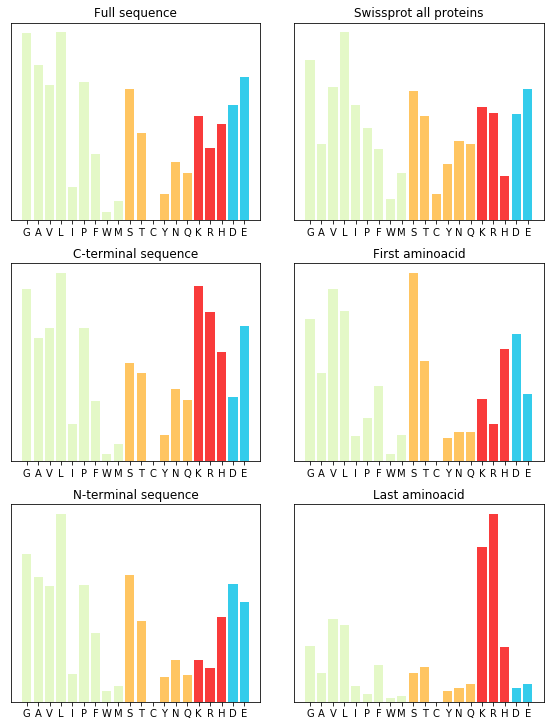

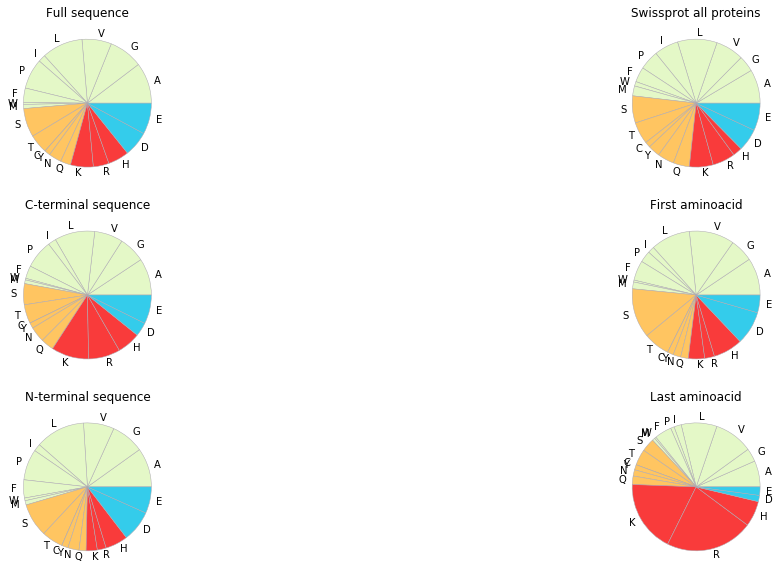

In [42]:

color=['#e4f8c7', '#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#ffc561','#ffc561','#ffc561','#ffc561','#ffc561','#ffc561','#f93b3b','#f93b3b','#f93b3b','#34cceb','#34cceb','#34cceb']


fig, ax1 = plt.subplots(3,2,figsize=(8,10))
ax1[0,0].bar(range(len(aminoacids)), list(aminoacids.values()), align='center', color=color)
ax1[2,0].bar(range(len(N_aminoacids)), list(N_aminoacids.values()), align='center', color=color)
ax1[1,0].bar(range(len(C_aminoacids)), list(C_aminoacids.values()), align='center', color=color)
ax1[1,1].bar(range(len(First_aa)), list(First_aa.values()), align='center', color=color)
ax1[2,1].bar(range(len(Last_aa)), list(Last_aa.values()), align='center', color=color)
ax1[0,1].bar(range(len(Normal_aminoacids)), list(Normal_aminoacids.values()), align='center', color=color)

ax1[0,0].set_title('Full sequence')
ax1[0,1].set_title('Swissprot all proteins')
ax1[2,0].set_title('N-terminal sequence')
ax1[1,0].set_title('C-terminal sequence')
ax1[1,1].set_title('First aminoacid')
ax1[2,1].set_title('Last aminoacid')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.setp(ax1, xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], xticklabels=['G','A','V','L','I','P','F','W','M','S','T','C','Y','N','Q','K','R','H','D','E'], yticks=([]))

fig, ax = plt.subplots(3,2,figsize=(20,10))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 

ax[0,0].pie(aminoacids.values(),labels = aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[2,0].pie(N_aminoacids.values(),labels =N_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,0].pie(C_aminoacids.values(),labels = C_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,1].pie(First_aa.values(),labels = First_aa.keys(), colors=color, wedgeprops=wp) 
ax[2,1].pie(Last_aa.values(),labels = Last_aa.keys(), colors=color, wedgeprops=wp) 
ax[0,1].pie(Normal_aminoacids.values(),labels = Normal_aminoacids.keys(), colors=color, wedgeprops=wp) 

ax[0,0].set_title('Full sequence')
ax[0,1].set_title('Swissprot all proteins')
ax[2,0].set_title('N-terminal sequence')
ax[1,0].set_title('C-terminal sequence')
ax[1,1].set_title('First aminoacid')
ax[2,1].set_title('Last aminoacid')

[ 7.26228405 -2.55701967]
0.5612248944032844


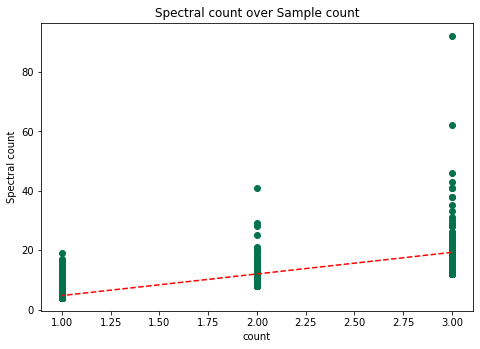

In [43]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['count'], df['Spectral count'], color='#04724d')
z = np.polyfit(df['count'], df['Spectral count'], 1)
p = np.poly1d(z)
plt.plot(df['count'],p(df['count']),"r--")
ax.set_xlabel('count')
ax.set_ylabel('Spectral count')
ax.set_title('Spectral count over Sample count')
fig.savefig('SPC_NINF.svg',transparent=True)

correlation_matrix = np.corrcoef(df['count'], df['Spectral count'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(z)
print(r_squared)

In [21]:
df.sort_values(['Spectral count'], ascending=False)[0:30]


,Peptide,Mass,Length,RT,Spectral count,Spectral count Sample 13,Spectral count Sample 21,Spectral count Sample 33,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,
sp|P02671|FIBA_HUMAN,MELERPGGNEITR,1510.058861,13.0,54.533333,92,16.0,35.0,40.0,3,MELE,EITR,M,R
sp|P02671|FIBA_HUMAN,MELERPGGNEIT,1352.016542,12.0,63.580556,62,16.0,32.0,13.0,3,MELE,NEIT,M,T
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.525000,9.0,57.370000,46,8.0,12.0,26.0,3,ANAL,HKYH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.614900,11.0,89.106667,43,13.0,13.0,17.0,3,GVAN,HKYH,G,H
sp|P69905|HBA_HUMAN,VGAHAGEYGAEALER,1528.726900,15.0,58.986667,41,16.0,14.0,11.0,3,VGAH,ALER,V,R
sp|P69905|HBA_HUMAN,AHVDDMPNALSALSDLHAH,2020.934850,19.0,95.225000,41,22.0,19.0,0.0,2,AHVD,LHAH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,1250.652000,12.0,96.916667,41,11.0,12.0,18.0,3,AGVA,HKYH,A,H
sp|P69905|HBA_HUMAN,MFLSFPTTK,1081.210333,9.0,97.713333,38,10.0,14.0,14.0,3,MFLS,PTTK,M,K
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,VVAGVANALAHKYH,1448.952800,14.0,88.780000,38,13.0,9.0,16.0,3,VVAG,HKYH,V,H


In [22]:
#Here we sort on the C and N-cut

df_N=df.groupby(['Accession', 'N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
df_N['Spectral count']=df_N['Spectral count']/number_of_files
df_N=df_N.sort_values(['Spectral count'], ascending=False)
df_C=df.groupby(['Accession', 'C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C['Spectral count']=df_C['Spectral count']/number_of_files
df_C=df_C.sort_values(['Spectral count'], ascending=False)

df_C.head()


Spectral count  \
Accession                               C-cut                   
sp|P69905|HBA_HUMAN                     LHAH       109.666667   
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN HKYH        83.666667   
sp|P69905|HBA_HUMAN                     ALER        57.666667   
                                        MPNA        56.666667   
sp|P02671|FIBA_HUMAN                    EITR        54.000000   

                                               Spectral count Sample 13  \
Accession                               C-cut                             
sp|P69905|HBA_HUMAN                     LHAH                      139.0   
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN HKYH                       64.0   
sp|P69905|HBA_HUMAN                     ALER                       59.0   
                                        MPNA                       50.0   
sp|P02671|FIBA_HUMAN                    EITR                       32.0   

                                               Spectral count Sample 21  \
Accession                               C-cut                             
sp|P69905|HBA_HUMAN                     LHAH                      161.0   
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN HKYH                       60.0   
sp|P69905|HBA_HUMAN                     ALER                       55.0   
                                        MPNA                       58.0   
sp|P02671|FIBA_HUMAN                    EITR                       65.0   

                                               Spectral count Sample 33  count  
Accession                               C-cut                                   
sp|P69905|HBA_HUMAN                     LHAH                       27.0     37  
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN HKYH                      127.0     21  
sp|P69905|HBA_HUMAN                     ALER                       59.0     28  
                                        MPNA                       62.0     22  
sp|P02671|FIBA_HUMAN                    EITR                       64.0     12

602
553


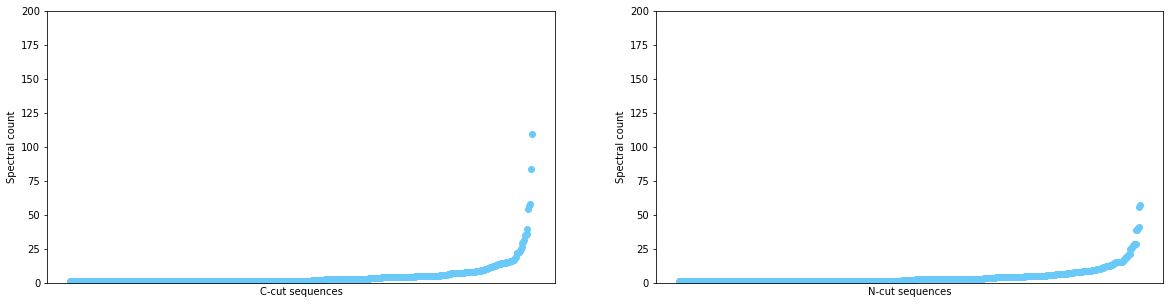

In [23]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.

df_N.reset_index(['Accession'], inplace=True)
df_C.reset_index(['Accession'], inplace=True)
df_C=df.groupby(['C-cut']).sum()
df_N=df.groupby(['N-cut']).sum()

df_N=df_N.sort_values('Spectral count')
df_C=df_C.sort_values('Spectral count')
fig, ax = plt.subplots(1,2,figsize=(20,5))
plt.setp(ax, ylim=(0,200))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count']/number_of_files, color='#34cceb') #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['Spectral count']/number_of_files, color='#34cceb') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))

In [24]:
#This adds the N/C-grouped column when df is grouped mainly on protein, although the index is removed, and then on N/C-cutsite which is kept. 
#It is therefore still indirectly sorted on protein. There is no "respective peptide" available, although this can be easily added by sorting on Peptide aswell.



df_N= df.groupby(['Accession','N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['count','Spectral count'], ascending=False) #sorts these values by count and feature
df_N.reset_index(['Accession'], inplace=True) #removes protein from index, only cut left
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead
df_N['Spectral count']=df_N['Spectral count']/number_of_files

df_N=df_N.sort_values(['Spectral count'], ascending=False) #sorts the grouped index on count and feature

df_C = df.groupby(['Accession','C-cut']).sum() 
df_C = df_C.sort_values(['count','Spectral count'], ascending=False)
df_C.reset_index(['Accession'], inplace=True)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C=df_C.groupby(['C-grouped']).sum()
df_C['Spectral count']=df_C['Spectral count']/number_of_files

df_C=df_C.sort_values(['Spectral count'], ascending=False)
df_N.head()


,Spectral count,Spectral count Sample 13,Spectral count Sample 21,Spectral count Sample 33,count
N-grouped,,,,,
NNNN,153.333333,77.0,157.0,226.0,87
NNNP,99.000000,58.0,104.0,135.0,45
NNBN,98.000000,43.0,45.0,206.0,48
NNPN,88.333333,56.0,70.0,139.0,47
NNNB,88.000000,47.0,85.0,131.0,45


150
162


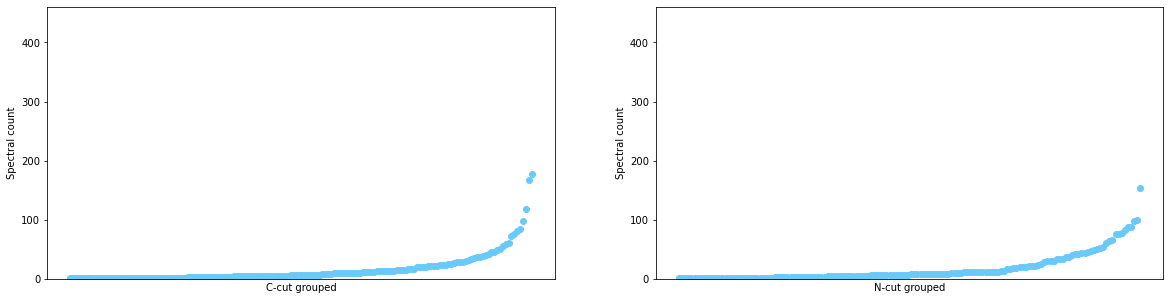

In [25]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
df_N=df_N.sort_values(['Spectral count'], ascending=True)
df_C=df_C.sort_values(['Spectral count'], ascending=True)
fig, ax = plt.subplots(1,2, figsize=(20,5))
plt.setp(ax, ylim=(0,460))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count'], color='#34cceb') #row=0, col=0
ax[0].scatter(df_C.index, df_C['Spectral count'], color='#34cceb') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))